In [3]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML
from base64 import b64encode

In [4]:
MoBiLSTM_model = tf.keras.models.load_model("modelnew.h5")


In [5]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16

In [7]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [8]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

plt.style.use("default")

In [12]:
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        ax=plt.subplot()
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()

In [10]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 76ms/step


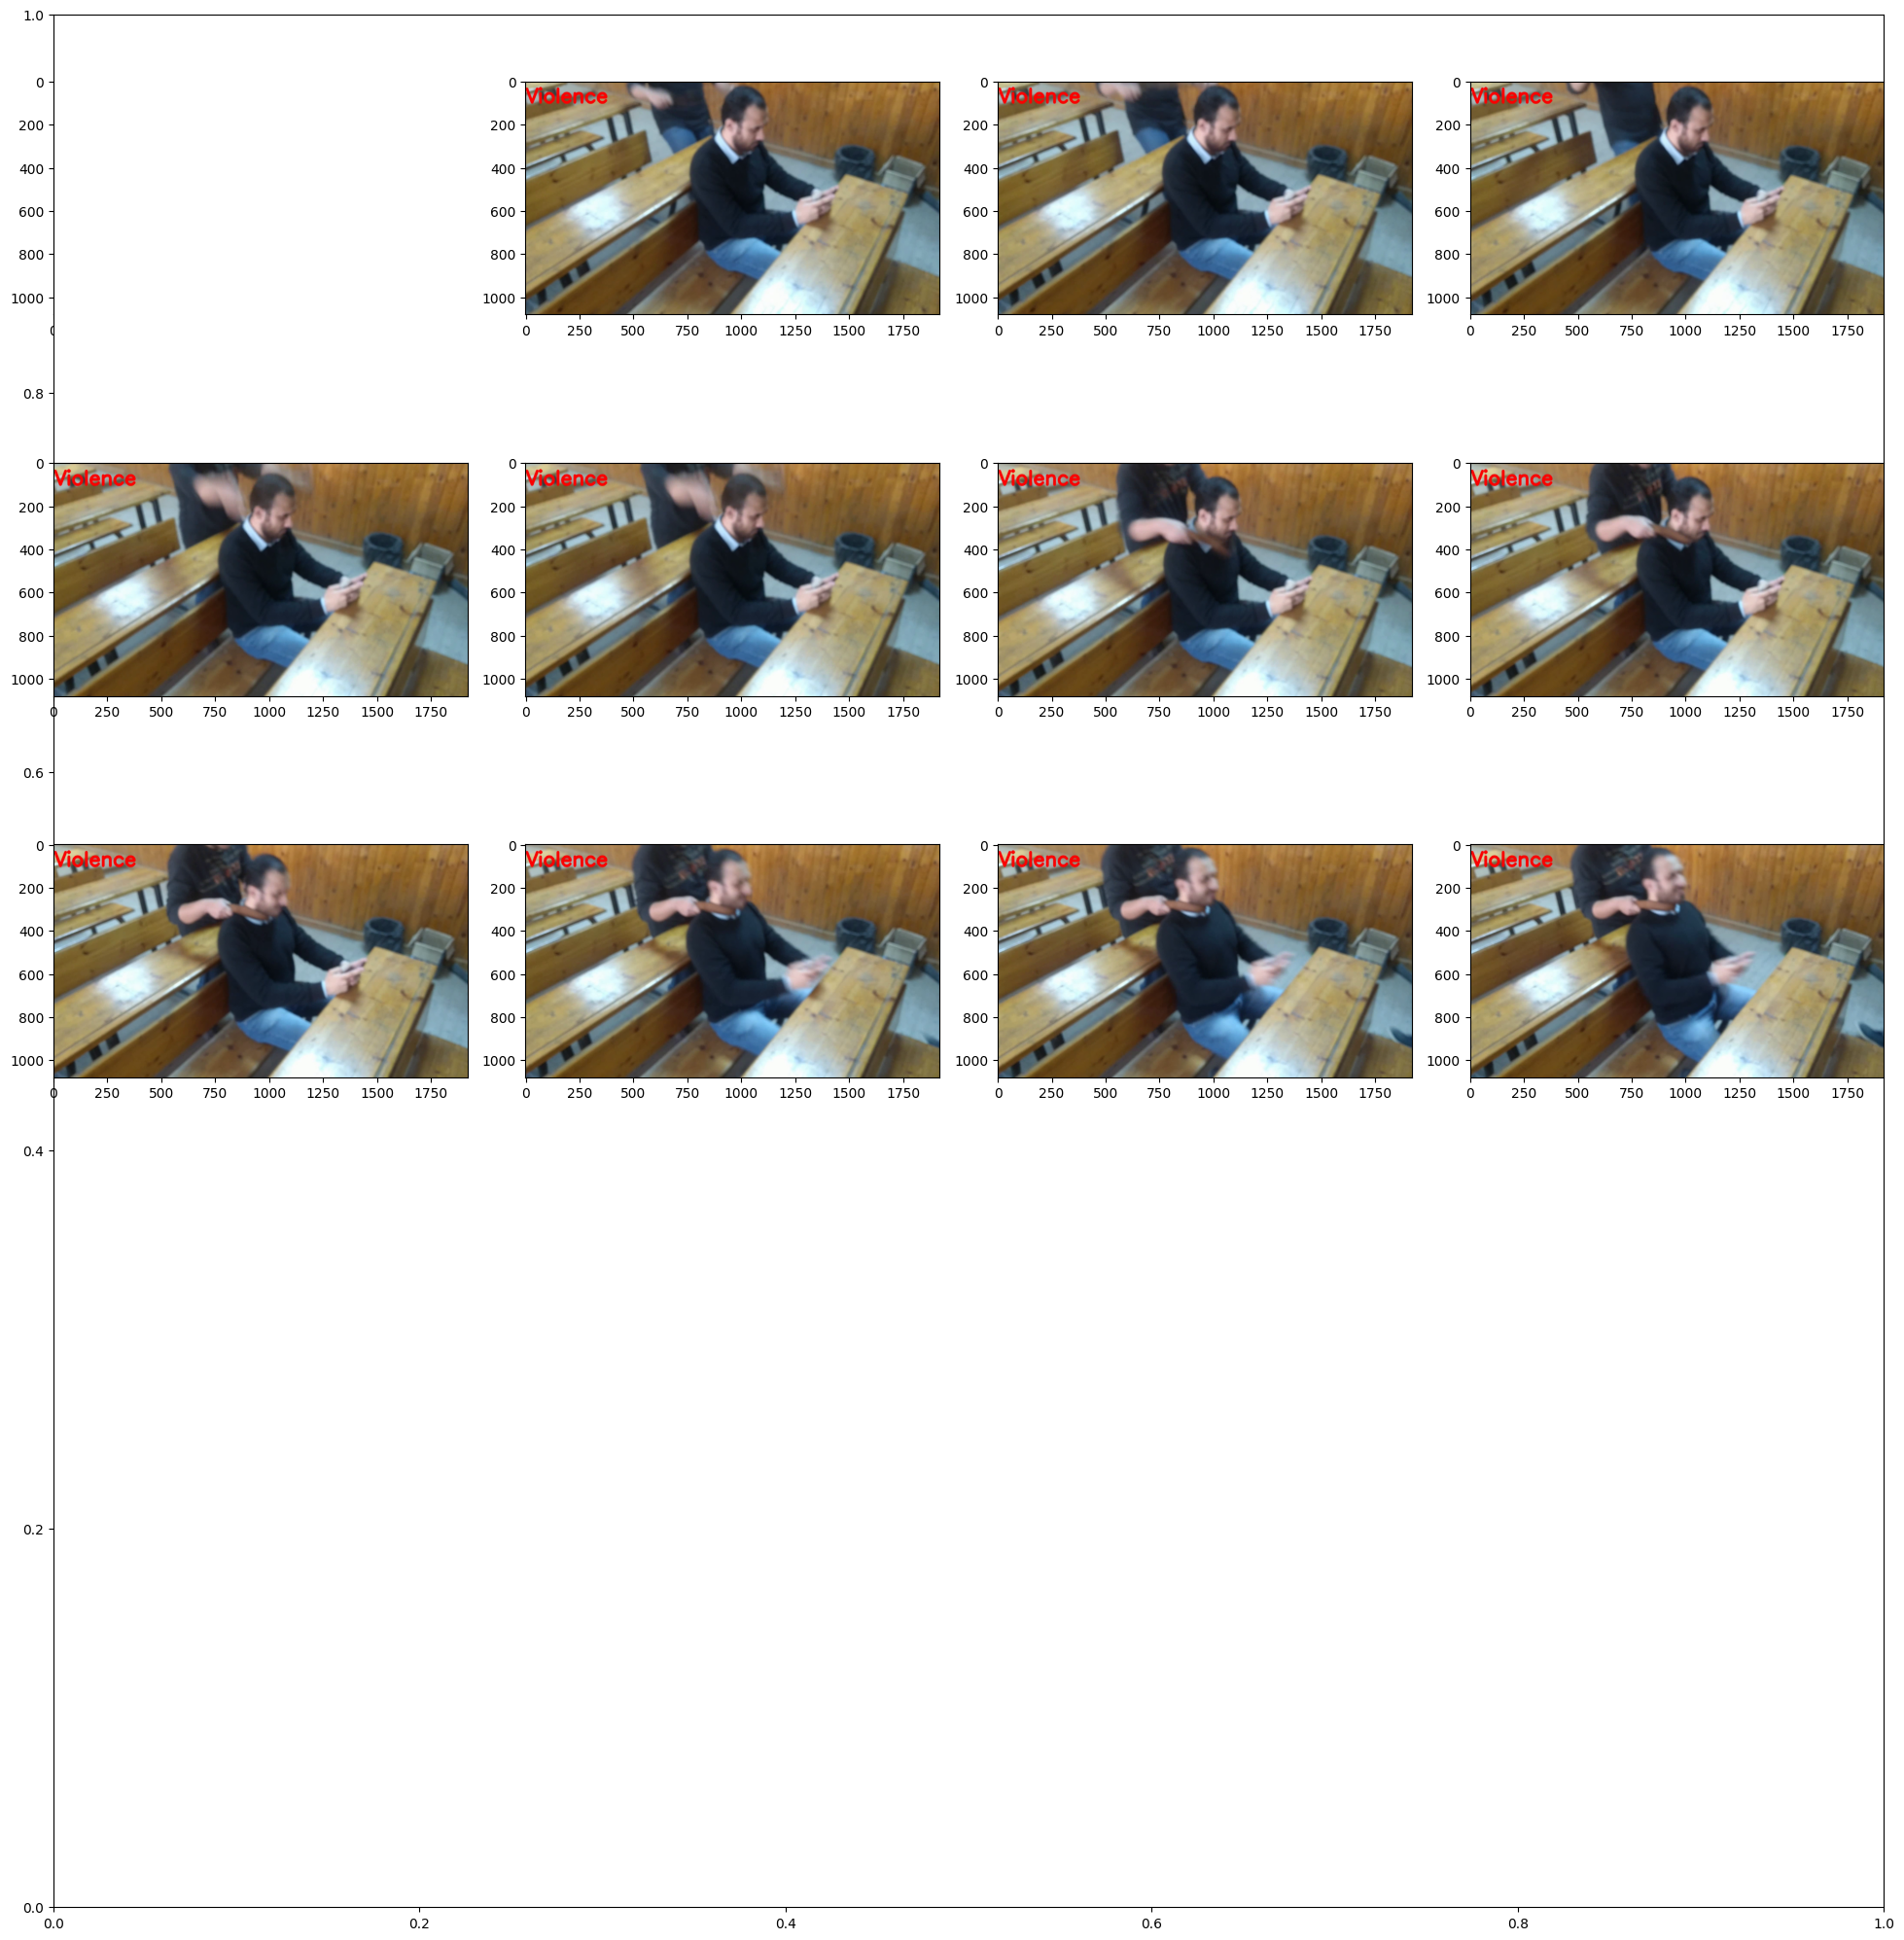

In [13]:
input_video_file_path = "Dataset/Violence/V_10.mp4"
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
show_pred_frames(output_video_file_path)
Play_Video(input_video_file_path)

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
from pytube import YouTube

def predict_video_from_url(video_url, sequence_length=16):
    try:
        # Get YouTube video details using pytube
        youtube_video = YouTube(video_url)
        video_stream = youtube_video.streams.filter(file_extension="mp4").first()
        video_stream_url = video_stream.url

        # Perform prediction on the video
        predict_video(video_stream_url, sequence_length)

    except Exception as e:
        print(f"Error: {e}")

In [ ]:
user_video_url = "https://www.youtube.com/watch?v=QC8iQqtG0hg&pp=ygUPNSBzZWNvbmRzIHZpZGVv"
predict_video_from_url(user_video_url)

1/1 [==============================] - 4s 4s/step
Predicted: NonViolence
Confidence: 0.9672051668167114
